In [1]:
!pip install -q snowflake-connector-python

In [2]:
insert = True
table_name         = 'scada'
result_path        = 'abfss://iceberg@onelake.dfs.fabric.microsoft.com/iceberg_result.Lakehouse/Tables/dbo/testresult'
tbl_path           = 'abfss://iceberg@onelake.dfs.fabric.microsoft.com/iceberg.Lakehouse/Tables/scada'

<mark>_<u>**Import**</u>_</mark>

In [3]:
from   deltalake.writer    import write_deltalake
from   datetime            import datetime
from   deltalake           import DeltaTable
import random
import pandas              as pd
import duckdb 
import snowflake.connector
import time

**<mark>connect to snowflake</mark>**

In [4]:
# this is a hack, use proper key vault to store credential
secret_path  = 'abfss://kv@onelake.dfs.fabric.microsoft.com/mysecrets.Lakehouse/Files/variable.ini'
kv =duckdb.sql(f""" select trim(split_part("[myvars]",' : ', 1) ) as var, trim(split_part("[myvars]",' : ', 2)) as values from read_csv('{secret_path}') """)
kv_values=duckdb.sql( " from kv where var in ('user' ,'password','account_snwo') ").fetchall()
for key, value in kv_values:
        globals()[key] = value
conn = snowflake.connector.connect(
    user               =  user,
    password           =  password,
    account            = account_snwo, 
    insecure_mode      = True
)
snow = conn.cursor()

**<mark>Insert into Snowflake Iceberg</mark>**

In [5]:
start_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

In [6]:
if insert  :
    limit = random.randint(3_000_000,100_000_000)
    print(limit)
    #snow.execute(f'  truncate table  ONELAKE.ICEBERG.scada ; ')
    snow.execute(f'  insert into  ONELAKE.ICEBERG.scada select * from ONELAKE.AEMO.SCADARAW limit {limit}; ')
    snow.execute(f'  delete from  ONELAKE.ICEBERG.scada where INITIALMW = 0 ')
    snow.execute(""" SELECT SYSTEM$GET_ICEBERG_TABLE_INFORMATION('ONELAKE.iceberg.scada'); """)

88938201


In [7]:
df =snow.execute('select count(*) as total from ONELAKE.ICEBERG.scada ;').fetch_pandas_all()
conn.close()
df['engine']   ='iceberg'
df['time']     = start_time
df['TOTAL']    = df['TOTAL'].astype('int64')
df['table']    = table_name
write_deltalake(result_path,df, mode="append")
print(df)

       TOTAL   engine                 time  table
0  252463631  iceberg  2025-05-07 00:32:25  scada


In [8]:
import time
time.sleep(15)

In [9]:
df            = duckdb.sql(f""" select cast(count(*) as int) as TOTAL from delta_scan('{tbl_path}') """).df()
df['engine']  ='delta'
df['time']    = start_time
df['TOTAL']   = df['TOTAL'].astype('int64')
df['table']   = table_name
write_deltalake(result_path,df, mode="append")
print(df)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

       TOTAL engine                 time  table
0  252463631  delta  2025-05-07 00:32:25  scada


**<mark>Results</mark>**

In [10]:
df = duckdb.sql(f"""
             pivot (from delta_scan('{result_path}'))
             on engine
             using min(TOTAL) order by time asc 
              """).df()

In [11]:
df

,time,table,delta,iceberg
0,2025-05-06 23:27:54,scada,34319423,34319423
1,2025-05-06 23:32:07,scada,34334482,34334482
2,2025-05-06 23:34:10,scada,34505097,34505097
3,2025-05-06 23:39:46,scada,34788105,34788105
4,2025-05-06 23:43:01,scada,36193692,36193692
5,2025-05-06 23:46:32,scada,37505955,37505955
6,2025-05-06 23:48:28,scada,51506097,51506097
7,2025-05-06 23:52:04,scada,65878169,65878169
8,2025-05-06 23:55:26,scada,80250241,80250241
9,2025-05-07 00:01:28,scada,94335085,94335085


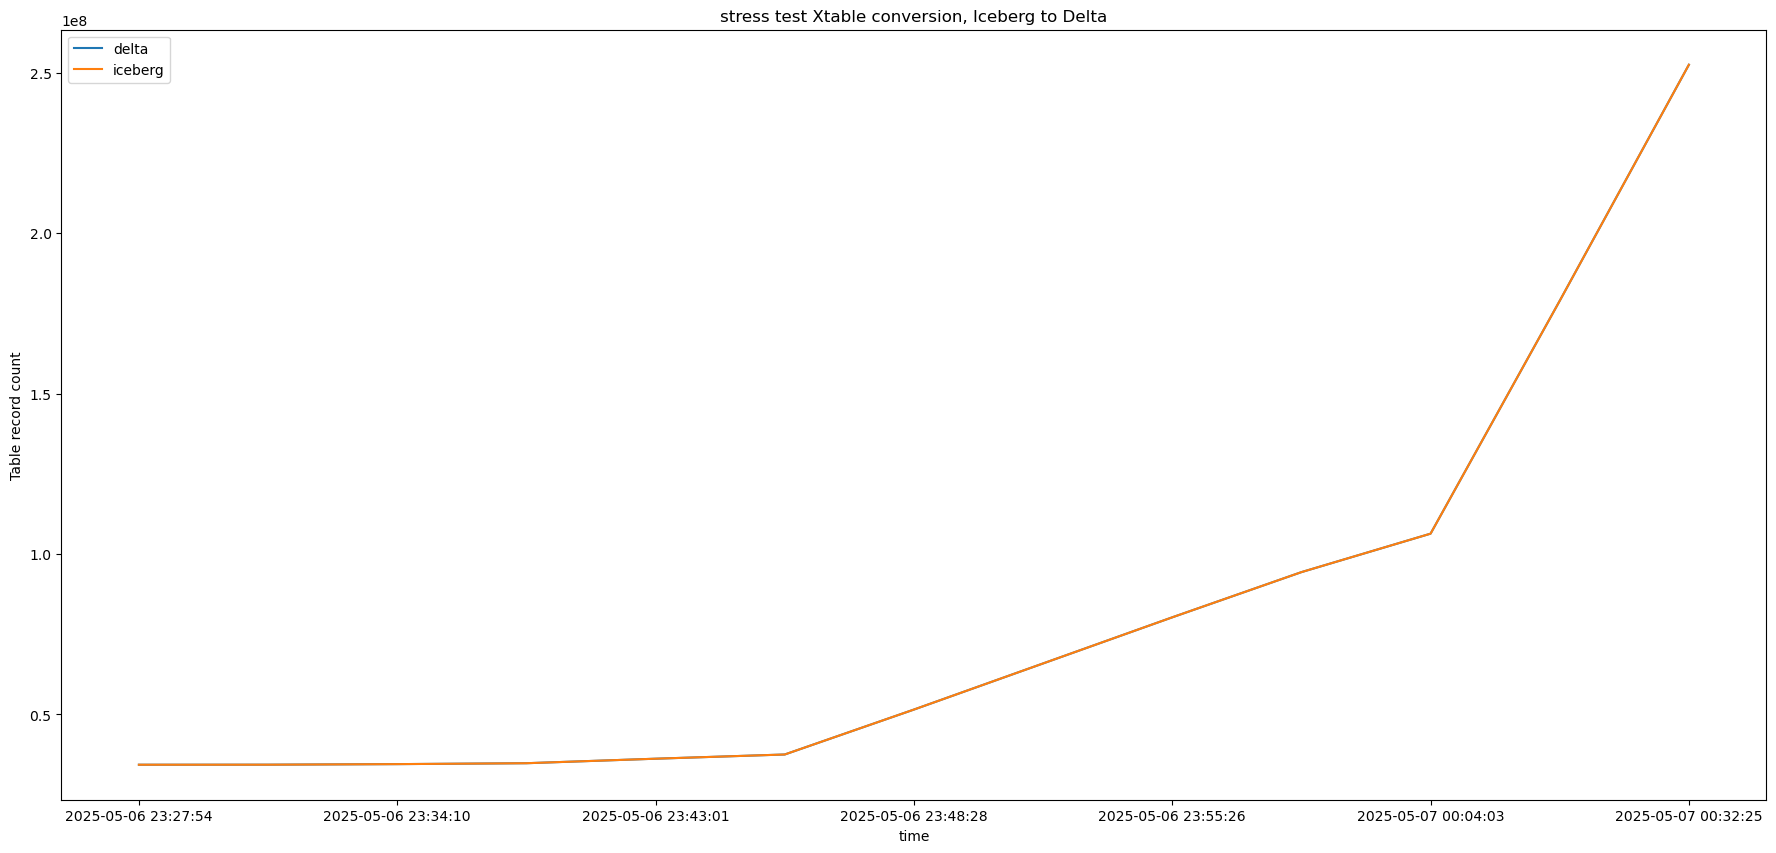

In [12]:
ax = df.plot.line(rot=0,x='time',y=['delta','iceberg'],title='stress test Xtable conversion, Iceberg to Delta', ylabel='Table record count',figsize=(22,10))
for c in ax.containers:
    ax.bar_label(c, label_type='edge')